<a href="https://www.kaggle.com/code/hellomomiji/capstone-project-gen-ai-intensive-course-2025q1?scriptVersionId=234150396" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Capstone Project - Gen AI Intensive Course 2025Q1

## 1. Problem Statement

In today's fast-paced business environment, effective meeting management has become more crucial than ever. With the rise of global teams and remote work, meetings often involve participants from different regions speaking various languages. This creates a need for tools that can not only summarize discussions but also make them accessible across language barriers.

I built a smart meeting assistant using LangGraph and Google's Gemini model that can:

- Extract key information from meeting transcripts
- Identify and organize action items with assignees
- Translate summaries into multiple languages
- Structure everything into a clean, organized format

## 2. Environment Setup

### 2.1 Get set up
Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

In [1]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install --upgrade langchain langchain-core langgraph langgraph-prebuilt langchain-google-genai
!pip install --upgrade google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.35
    Uninstalling langchain-core-0.3.35:
      Successfully uninstalled langchain-core-0.3.35
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitt

In [2]:
from google import genai
from google.genai import types

genai.__version__

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


'0.8.0'

### 2.2 Setup API Key

In [3]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## 3. Define Data Schemas

In [4]:
# Define the JSON schema for structured output
import json

meeting_schema = {
  "type": "object",
  "properties": {
    "title": {
      "type": "string",
      "description": "The title or topic of the meeting"
    },
    "summary": {
      "type": "string",
      "description": "A concise summary of the meeting discussion (1-3 sentences)"
    },
    "key_points": {
      "type": "array",
      "items": {
        "type": "string"
      },
      "description": "List of 3-5 important points discussed in the meeting"
    },
    "action_items": {
      "type": "array",
      "items": {
        "type": "object",
        "properties": {
          "task": {
            "type": "string",
            "description": "Description of the task to be completed"
          },
          "assignee": {
            "type": "string",
            "description": "Name of the person assigned to the task"
          },
          "due_date": {
            "type": "string",
            "description": "Due date or deadline for the task (if mentioned)"
          }
        },
        "required": ["task", "assignee"]
      },
      "description": "List of tasks assigned during the meeting"
    }
  },
  "required": ["title", "summary", "action_items"]
}

## 4. Define the Agent Using LangGraph

In [5]:
from typing import TypedDict, Annotated, List, Dict, Any
from typing_extensions import NotRequired

from langgraph.graph.message import add_messages

# Define the state for LangGraph
class MeetingState(TypedDict):
    """State for the meeting processing graph."""
    transcript: str
    title: str
    summary: str
    key_points: List[str]
    action_items: List[Dict]
    translations: Dict[str, Dict]
    should_translate: bool
    target_languages: List[str]

## 5. Create Few-Shot Prompt Examples

In [6]:
# Define few-shot examples for better prompting
few_shot_examples = [
    {
        "transcript": 
            """
            John: Good morning everyone, let's get started with our weekly product update. 
            Sarah: Great, I finished the frontend design for the user dashboard.
            John: Excellent work, Sarah. Tom, what's the status on the API integration?
            Tom: I'm about 70% complete. I need another three days to finish testing.
            John: Understood. Please make sure it's done by Friday. 
            Emma: I've completed the user documentation but we need to review it before release.
            John: Emma, can you work with Sarah to get that reviewed by Thursday?
            Emma: Sure, I'll schedule time with Sarah tomorrow.
            John: Perfect. Let's meet again next Monday to finalize everything for the release.
            """,
        "output": {
            "title": "Weekly Product Update Meeting",
            "summary": "The team discussed progress on the user dashboard, API integration, and documentation. Several tasks were assigned to meet the upcoming release schedule.",
            "key_points": [
                "Sarah completed frontend design for user dashboard",
                "Tom is 70% done with API integration",
                "Emma completed user documentation that needs review"
            ],
            "action_items": [
                {"task": "Finish API integration testing", "assignee": "Tom", "due_date": "Friday"},
                {"task": "Review user documentation", "assignee": "Emma & Sarah", "due_date": "Thursday"},
                {"task": "Schedule follow-up meeting", "assignee": "John", "due_date": "Next Monday"}
            ]
        }
    },
    {
        "transcript": 
            "Lisa: Welcome to our marketing strategy meeting. We need to finalize our Q2 campaign.\nMark: I've drafted the social media content plan. It covers Facebook, Instagram, and Twitter.\nLisa: Great job. Have you coordinated with the design team on visuals?\nMark: Not yet. I need to set up a meeting with them by Wednesday.\nJennifer: I've analyzed our Q1 performance. Our conversion rate increased by 15% but our CPC is still too high.\nLisa: Jennifer, can you prepare a detailed report by Friday to help us optimize our ad spend?\nJennifer: Yes, I'll have it ready.\nMark: I also need access to the new analytics platform to track campaign performance.\nLisa: I'll ask IT to set you up by tomorrow. Everyone, please send me your final content needs by Thursday so we can launch next Monday.",
          "output": {
            "title": "Q2 Marketing Campaign Planning",
            "summary": "The team discussed the Q2 marketing campaign, including social media content plans and Q1 performance analysis, with a focus on improving conversion rates and optimizing ad spend.",
            "key_points": [
              "Social media content plan drafted for Facebook, Instagram, and Twitter",
              "Q1 conversion rate increased by 15%, but CPC remains high",
              "Campaign launch scheduled for next Monday"
            ],
            "action_items": [
              {"task": "Coordinate with design team on visuals", "assignee": "Mark", "due_date": "Wednesday"},
              {"task": "Prepare detailed Q1 performance report", "assignee": "Jennifer", "due_date": "Friday"},
              {"task": "Set up analytics platform access for Mark", "assignee": "Lisa", "due_date": "Tomorrow"},
              {"task": "Submit final content needs", "assignee": "Everyone", "due_date": "Thursday"},
              {"task": "Launch Q2 campaign", "assignee": "Team", "due_date": "Next Monday"}
            ]
          }
        }
]

## 6. Core Processing Functions

In [7]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, add_messages
from langchain_core.tools import tool, ToolException

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

### 6.1 First Tool: Generate Meeting Summary

In [8]:
# Create the prompt template with few-shot examples
generate_summary_prompt = """
    You are an AI assistant that processes meeting transcripts.
    Extract the following from this meeting transcript:
    1. A clear meeting title
    2. A concise summary (1-3 sentences)
    3. 3-5 key points from the discussion

    Here are some examples of how you should process meeting transcripts:
    
    EXAMPLE 1:
    Transcript:
    {example1_transcript}
    
    Expected Output:
    {example1_output}
    
    EXAMPLE 2:
    Transcript:
    {example2_transcript}
    
    Expected Output:
    {example2_output}
    
    Now, process the following meeting transcript:
    
    Transcript:
    {transcript}
    
    Format your response as a JSON object with these keys: "title", "summary", "key_points".
    """

In [9]:
@tool(description="Generate a title, summary, and key points for a meeting transcript.")
def generate_summary_tool(transcript: str) -> Dict:
    print("Start generating meeting summary...")
    parser = JsonOutputParser()
    
    formatted_prompt = generate_summary_prompt.format(
        example1_transcript=few_shot_examples[0]["transcript"],
        example1_output=json.dumps({
            "title": few_shot_examples[0]["output"]["title"], 
            "summary": few_shot_examples[0]["output"]["summary"], 
            "key_points": few_shot_examples[0]["output"]["key_points"]
        }, indent=2),
        example2_transcript=few_shot_examples[1]["transcript"],
        example2_output=json.dumps({
            "title": few_shot_examples[1]["output"]["title"], 
            "summary": few_shot_examples[1]["output"]["summary"], 
            "key_points": few_shot_examples[1]["output"]["key_points"]
        }, indent=2),
        transcript=transcript,
    )
    try:
        # Process the transcript
        result = llm.invoke(formatted_prompt)
        raw_content = result.content.strip('```json').strip('```').strip()
        parsed = parser.parse(raw_content)
        print("Meeting Summary successfully generated!")
        return parsed
        
    except Exception as e:
        raise ToolException(f"Failed to generate summary: {str(e)}")

### 6.2 Second Tool: Extract Action Items

In [10]:
extract_action_items_prompt = """
    You are an AI assistant that identifies action items from meeting transcripts.
    
    Extract all action items mentioned in this transcript. For each action item, identify:
    1. The specific task to be completed
    2. The person assigned to the task
    3. Any mentioned due date or deadline
    
    Here are some examples of how you should extract action items:
    
    EXAMPLE 1:
    Transcript:
    {example1_transcript}
    
    Expected Action Items:
    {example1_action_items}
    
    EXAMPLE 2:
    Transcript:
    {example2_transcript}
    
    Expected Action Items:
    {example2_action_items}
    
    Now, extract action items from the following meeting transcript:
    
    Transcript:
    {transcript}
    
    Format your response as a JSON object with an "action_items" key containing an array of objects.
    Each object should have "task", "assignee", and "due_date" fields.
    """

In [11]:
@tool(description="Extract action items with assignees and due dates from a meeting transcript.")
def extract_action_items_tool(transcript: str) -> Dict:
    print("Start extractomg action items...")
    parser = JsonOutputParser()
    
    try:
        # Process the transcript
        formatted_prompt = extract_action_items_prompt.format(
            example1_transcript=few_shot_examples[0]["transcript"],
            example1_action_items=json.dumps({"action_items": few_shot_examples[0]["output"]["action_items"]}, indent=2),
            example2_transcript=few_shot_examples[1]["transcript"],
            example2_action_items=json.dumps({"action_items": few_shot_examples[1]["output"]["action_items"]}, indent=2),
            transcript=transcript,
        )
        result = llm.invoke(formatted_prompt)
        raw_content = result.content.strip("```json\n").strip("```")
        parsed = parser.parse(raw_content)
        print("Action Items successfully extracted!")
        return parsed
        
    except Exception as e:
        raise ToolException(f"Failed to extract action items: {str(e)}")

### 6.3 Third Tool: Translate into a target language

In [12]:
translate_prompt = """
    You are a professional translator. 
    Translate the following meeting content into {target_language}.
    Maintain the professional tone and technical terms accurately.
    
    Content to translate:
    Title: {title}
    
    Summary: {summary}
    
    Key Points:
    {key_points}
    
    Action Items:
    {action_items}
    
    Return your translation as a JSON object with the following structure:
    {{
      "title": "translated title",
      "summary": "translated summary",
      "key_points": ["translated point 1", "translated point 2", ...],
      "action_items": [
        {{"task": "translated task", "assignee": "same assignee name", "due_date": "same date"}}
      ]
    }}
    
    Keep the original assignee names unchanged. Preserve all dates exactly as they appear.
"""

In [13]:
@tool(description="Translate meeting content into the specified language.")
def translate_meeting_content_tool(meeting_content: Dict) -> Dict:    

    # Unpack the parameters from the dictionary
    title = meeting_content["title"]
    summary = meeting_content["summary"]
    key_points = meeting_content["key_points"]
    action_items = meeting_content["action_items"]
    target_language = meeting_content["target_language"]
    
    print(f"Start translating meeting content into {target_language}...")
    parser = JsonOutputParser()

    # Prepare action items for display in the prompt
    action_items_text = "\n".join([
        f"- {item['task']} (Assigned to: {item['assignee']}" + 
        (f", Due: {item['due_date']}" if 'due_date' in item else "") + ")"
        for item in action_items
    ])

    # Format key points for display
    key_points_text = "\n".join([f"- {point}" for point in key_points])

    formatted_prompt = translate_prompt.format(
            title=title,
            summary=summary,
            key_points=key_points_text,
            action_items=action_items_text,
            target_language=target_language
    )

    try:
        result = llm.invoke(formatted_prompt)
        raw_content = result.content.strip('```json').strip('```').strip()
        parsed = parser.parse(raw_content)
        print(f"Meeting content successfully translated into {target_language}!")
        return parsed
        
    except Exception as e:
        raise ToolException(f"Failed to translate content: {str(e)}")

## 7. Define Graph Nodes

In [14]:
# Define Graph Nodes
def generate_meeting_summary(state: MeetingState) -> MeetingState:
    """Node to generate meeting summary."""
    result = generate_summary_tool(state["transcript"])
    
    return {
        **state,
        "title": result["title"],
        "summary": result["summary"],
        "key_points": result["key_points"]
    }

In [15]:
def extract_meeting_action_items(state: MeetingState) -> MeetingState:
    """Node to extract action items."""
    result = extract_action_items_tool(state["transcript"])
    
    return {
        **state,
        "action_items": result["action_items"]
    }

In [16]:
def translate_meeting_content(state: MeetingState) -> MeetingState:
    """Node to translate meeting content into specified languages."""
    translations = {}

    target_languages = state["target_languages"]
        
    for language in target_languages:
        meeting_content = {
            "title": state["title"],
            "summary": state["summary"],
            "key_points": state["key_points"],
            "action_items": state["action_items"],
            "target_language": language
        }
        result = translate_meeting_content_tool.invoke({"meeting_content": meeting_content})
        translations[language] = result

    return {
        **state,
        "translations": translations
    } 

## 8. Create Graph

In [17]:
from langgraph.graph import StateGraph, START, END

def create_meeting_graph():
    """Create and compile the meeting processing graph."""
    # Initialize the graph with our state
    workflow = StateGraph(MeetingState)
    
    # Add nodes
    workflow.add_node("generate_summary", generate_meeting_summary)
    workflow.add_node("extract_action_items", extract_meeting_action_items)
    workflow.add_node("translate_content", translate_meeting_content)

    # Add conditional edges for translation
    def should_translate(state: MeetingState) -> str:
        if state.get("should_translate", False):
            return "translate"
        return "end"
    
    # Define the flow
    workflow.add_edge(START, "generate_summary")
    workflow.add_edge("generate_summary", "extract_action_items")
    workflow.add_conditional_edges(
        "extract_action_items",
        should_translate,
        {
            "translate": "translate_content",
            "end": END
        }
    )
    workflow.add_edge("translate_content", END)
    
    # Compile the graph
    return workflow.compile()

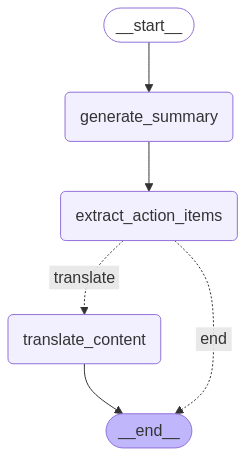

In [18]:
from IPython.display import Image, display
graph = create_meeting_graph()
Image(graph.get_graph().draw_mermaid_png())

## 9. Create main function to process meeting transcript

In [19]:
# Main function to process a meeting transcript
def process_meeting(transcript: str, should_translate: bool = False, target_languages: List[str] = []) -> Dict:
    """Process a meeting transcript and return structured data."""
    # Create the graph
    graph = create_meeting_graph()
    
    # Initialize the state with the transcript
    initial_state = {
        "transcript": transcript,
        "should_translate": should_translate,
        "target_languages": target_languages
    }
    print("Processing the meeting content...")
    print(f"transcript length: {len(transcript)}, shoud_translate: {should_translate}, target_languages: {', '.join(target_languages)}")
    
    # Execute the graph
    final_state = graph.invoke(initial_state)
    
    # Return the results
    result =  {
        "title": final_state.get("title", ""),
        "summary": final_state.get("summary", ""),
        "key_points": final_state.get("key_points", []),
        "action_items": final_state.get("action_items", [])
    }

    if "translations" in final_state:
        result["translations"] = final_state["translations"]

    return result

## 10. Test Functions

In [20]:
test_transcript = """
[09:00 AM] Sarah: Good morning, everyone. Let’s begin today’s product launch planning meeting. First, let's review our progress on the Q2 roadmap.

[09:02 AM] John: Engineering finished the backend integration. We're ready to start final QA.

[09:04 AM] Li Wei (李伟): 后端功能都已经完成了。我们现在在准备进行最终的质量测试。（The backend features are done. We're now preparing for final QA.）

[09:05 AM] Yuki (ゆき): デザインチームは、来週までに最終的なUIモックアップを提出する予定です。（The design team will submit final UI mockups by next week.）

[09:07 AM] Sarah: Great. Please make sure the design is aligned with the accessibility guidelines.

[09:08 AM] John: Will do. Also, we need a decision on which analytics platform to integrate.

[09:09 AM] Li Wei: 我推荐我们继续使用 Firebase。数据仪表板和报警功能都比较完善。（I recommend we stick with Firebase. It has good dashboards and alerting features.）

[09:10 AM] Sarah: Noted. Let’s test both Firebase and Mixpanel in staging by Thursday. Then we can make a decision.

[09:12 AM] Yuki: 木曜日までに両方のプラットフォームでテストします。それから、最終的な選定を行いましょう。（We’ll test both platforms by Thursday and decide after that.）

[09:15 AM] Sarah: Perfect. Now, let’s talk launch prep. We'll need updated copy for the landing page.

[09:16 AM] John: I can coordinate with marketing on that.

[09:17 AM] Li Wei: 我可以处理中文版本的着陆页内容。（I can handle the Chinese version of the landing page content.）

[09:18 AM] Yuki: 日本語の翻訳は私に任せてください。（I’ll take care of the Japanese translation.）

[09:20 AM] Sarah: Thanks! Lastly, let’s schedule a final review meeting. How about next Monday at 10 AM Pacific?

[09:21 AM] Everyone: Sounds good.

[09:22 AM] Sarah: Action items before we close:
- John to coordinate with marketing for English content
- Li Wei for Chinese copy
- Yuki for Japanese translation
- Test Firebase and Mixpanel on staging by Thursday
- Design team to finalize UI mockups by next week

[09:24 AM] Yuki: 了解です！（Got it!）
[09:24 AM] Li Wei: 明白了。
[09:25 AM] John: On it.
[09:25 AM] Sarah: Thanks all. Talk soon!
"""

In [21]:
# Test function
def test_meeting_agent(transcript: str, should_translate: bool = False, target_languages: List[str] = []):
    """Test the meeting agent with a sample transcript."""
    
    print("Processing meeting transcript with translations...")
    
    result = process_meeting(test_transcript, should_translate, target_languages)
    
    # Print results in a formatted way
    print("\n" + "="*50)
    print(f"MEETING TITLE: {result['title']}")
    print("="*50)
    
    print("\nSUMMARY:")
    print(result['summary'])
    
    print("\nKEY POINTS:")
    for idx, point in enumerate(result['key_points'], 1):
        print(f"{idx}. {point}")
    
    print("\nACTION ITEMS:")
    for idx, item in enumerate(result['action_items'], 1):
        due_date = item.get('due_date', 'Not specified')
        print(f"{idx}. {item['task']} (Assigned to: {item['assignee']}, Due: {due_date})")

    if result.get("translations", {}):
        # Print translations
        print("\n" + "="*50)
        print("TRANSLATIONS")
        print("="*50)

    for language, translation in result.get("translations", {}).items():
        print(f"\n--- {language} ---")
        print(f"TITLE: {translation['title']}")
        print(f"SUMMARY: {translation['summary']}")
        
        print("\nKEY POINTS:")
        for idx, point in enumerate(translation['key_points'], 1):
            print(f"{idx}. {point}")
        
        print("\nACTION ITEMS:")
        for idx, item in enumerate(translation['action_items'], 1):
            due_date = item.get('due_date', 'Not specified')
            print(f"{idx}. {item['task']} (Assigned to: {item['assignee']}, Due: {due_date})")
    
    
    # Save the result to a JSON file
    with open('meeting_output_with_translations.json', 'w') as f:
        json.dump(result, f, indent=2)
    print("\nResults also saved to 'meeting_output_with_translations.json'")
    
    return result

In [22]:
test_meeting_agent(
    transcript=test_transcript,
    should_translate=True,
    target_languages=["Chinese", "Japanese"]
)

Processing meeting transcript with translations...
Processing the meeting content...
transcript length: 1937, shoud_translate: True, target_languages: Chinese, Japanese
Start generating meeting summary...


/tmp/ipykernel_13/3783085128.py:4: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = generate_summary_tool(state["transcript"])


Meeting Summary successfully generated!
Start extractomg action items...
Action Items successfully extracted!
Start translating meeting content into Chinese...
Meeting content successfully translated into Chinese!
Start translating meeting content into Japanese...
Meeting content successfully translated into Japanese!

MEETING TITLE: Q2 Product Launch Planning Meeting

SUMMARY:
The team discussed progress on the Q2 product launch, including backend integration, UI mockups, and analytics platform selection. Action items were assigned for landing page content in English, Chinese, and Japanese, as well as testing Firebase and Mixpanel.

KEY POINTS:
1. Backend integration is complete and ready for final QA
2. Design team will submit final UI mockups by next week
3. Firebase and Mixpanel will be tested in staging by Thursday to determine which analytics platform to use
4. Landing page content updates needed in English, Chinese, and Japanese
5. Final review meeting scheduled for next Monday 

{'title': 'Q2 Product Launch Planning Meeting',
 'summary': 'The team discussed progress on the Q2 product launch, including backend integration, UI mockups, and analytics platform selection. Action items were assigned for landing page content in English, Chinese, and Japanese, as well as testing Firebase and Mixpanel.',
 'key_points': ['Backend integration is complete and ready for final QA',
  'Design team will submit final UI mockups by next week',
  'Firebase and Mixpanel will be tested in staging by Thursday to determine which analytics platform to use',
  'Landing page content updates needed in English, Chinese, and Japanese',
  'Final review meeting scheduled for next Monday at 10 AM Pacific'],
 'action_items': [{'task': 'Coordinate with marketing for English landing page content',
   'assignee': 'John',
   'due_date': None},
  {'task': 'Handle Chinese version of landing page content',
   'assignee': 'Li Wei',
   'due_date': None},
  {'task': 'Handle Japanese translation of land